DNN Has changed in 17-6 version 2

Dựa và PCA co thể tính được y pred proba dựa vào sự khác biệt nhiều hay it giữa invertransform và original (gần 0 là khác biệt ít, gần 1 là khác biệt nhie6u2). Vấn đề ở chỗ làm sao xác định được threshold ? Tức là thuật toán này không có model.predict, nó chỉ có model.preddict_proba mà thôi. Nếu mặc định threshold là 0.5 thì kết quả không ổn. Như vậy phải khảo sát threshold optimal ? Optimal này chỉ phụ thuộc vào y train và y predict proba

In [1]:
# Load basic library
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import random
from sklearn.externals import joblib 
from scipy import stats
import itertools

# Load Keras
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2
from keras.layers import Dropout

#Load sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle

from sklearn.metrics import log_loss 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score,balanced_accuracy_score
from sklearn.metrics import average_precision_score 

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, NMF

#ML normal ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#ML ensembles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

#Special
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

#Load visual neural:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

# import require packages for plotting
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import altair as alt # no need to add altviewer
from pandas.plotting import scatter_matrix


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


As a reminder, we have 284,807 credit card transactions in total, of which
492 are fraudulent, with a positive (fraud) label of one. The rest are
normal transactions, with a negative (not fraud) label of zero.
We have 30 features to use for anomaly detection—time, amount, and 28
principal components. And, we will split the dataset into a training set
(with 190,820 transactions and 330 cases of fraud) and a test set (with the
remaining 93,987 transactions and 162 cases of fraud):

In [2]:
# Load datasets
#current_path = os.getcwd()
#file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'credit_card.csv'])
file='https://media.githubusercontent.com/media/aapatel09/handson-unsupervised-learning/master/datasets/credit_card_data/credit_card.csv'
data = pd.read_csv(file)

dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].copy()

featuresToScale = dataX.columns
sX =StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.30, \
                    random_state=2018, stratify=dataY)

In [3]:
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
252400,1.284010,1.055295,-0.010751,-0.712706,0.280704,-0.052213,-0.876401,0.173987,-0.299533,0.432059,0.054741,-0.701580,0.668497,0.546831,0.186007,-0.007643,-0.124704,-0.397095,-1.082294,0.204109,-0.249506,-0.391982,-0.925970,0.523618,-0.018828,-0.526180,0.410968,-0.167836,-0.180421,-0.346073
171895,0.548625,1.006053,-0.460619,-1.102435,-0.450387,1.206518,2.947251,-1.054417,0.886446,1.010886,0.021803,-0.212471,0.371379,-0.022406,-0.064894,0.837898,0.278774,-0.667545,-0.152528,-0.483115,-0.143639,0.218307,0.777441,0.324419,1.254516,-0.470548,1.221701,-0.000626,-0.160412,-0.307251
135426,-0.285669,-0.731099,0.317777,1.725704,1.881673,-0.126631,1.265325,-0.524671,0.918829,-0.545192,-0.235698,-0.033822,1.327641,0.396111,-0.605414,-2.764306,-0.566119,0.732276,-0.415015,0.899800,0.137483,-0.117981,-0.238605,-0.246468,-0.439275,0.440789,0.209601,0.015633,-0.168490,-0.204221
178814,0.610241,-4.021913,-3.869072,-2.318957,0.695530,4.534704,-2.697238,-1.210103,-4.343034,1.389733,0.846635,-1.738247,0.065600,-0.126018,0.410346,-0.094308,0.173249,-1.086759,-0.440417,0.795971,-9.423919,2.901720,1.381553,4.959889,-1.353827,0.896515,-0.270573,7.598828,-1.499358,-0.349231
129784,-0.328543,0.615128,-0.170915,0.603772,-0.558176,-0.639049,-0.238178,-0.438886,0.012891,1.436250,-1.074956,0.051944,1.669866,1.529781,-0.454359,1.475277,-0.923573,0.050725,-0.543486,0.229564,-0.072717,0.045605,0.631666,-0.040258,0.233515,0.922587,-1.373199,0.298497,0.106900,-0.349231


In [4]:
y_train.value_counts(normalize=True)

0    0.998275
1    0.001725
Name: Class, dtype: float64

In [5]:
y_test.value_counts(normalize=True)

0    0.998268
1    0.001732
Name: Class, dtype: float64

# Define evaluation functions

In [6]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

# Define Evaluation Metrics

Although we will not use the fraud labels to build the unsupervised fraud
detection solutions, we will use the labels to evaluate the unsupervised
solutions we develop. The labels will help us understand just how well
these solutions are at catching known patterns of fraud.
As we did in Chapter 2, we will use the precision-recall curve, the average
precision, and the auROC as our evaluation metrics.
Here is the function that will plot these results:

In [7]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

The fraud labels and the evaluation metrics will help us assess just how good the
unsupervised fraud detection systems are at catching known patterns of fraud—fraud
that we have caught in the past and have labels for.
However, we will not be able to assess how good the unsupervised fraud detection
systems are at catching unknown patterns of fraud. In other words, there may be
fraud in the dataset that is incorrectly labeled as not fraud because the financial
company never discovered it.
As you may see already, unsupervised learning systems are much harder to evaluate
than supervised learning systems. Often, unsupervised learning systems are judged
by their ability to catch known patterns of fraud. This is an incomplete assessment; a
better evaluation metric would be to assess them on their ability to identify unknown
patterns of fraud, both in the past and in the future.
Since we cannot go back to the financial company and have them evaluate any
unknown patterns of fraud we identify, we will have to evaluate these unsupervised
systems solely based on how well they detect the known patterns of fraud. It’s
important to be mindful of this limitation as we proceed in evaluating the results.

# Define Plotting Function

We will reuse the scatterplot function from Chapter 3 to display the
separation of points the dimensionality reduction algorithm achieves in
just the first two dimensions:

In [8]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

# PCA OK

In Chapter 3, we demonstrated how PCA captured the majority of
information in the MNIST digits dataset in just a few principal
components, far fewer in number than the original dimensions. In fact,
with just two dimensions, it was possible to visually separate the images
into distinct groups based on the digits they displayed.

Building on this concept, we will now use PCA to learn the underlying
structure of the credit card transactions dataset. Once we learn this
structure, we will use the learned model to reconstruct the credit card
transactions and then calculate how different the reconstructed
transactions are from the original transactions. Those transactions that
PCA does the poorest job of reconstructing are the most anomalous (and
most likely to be fraudulent).

However, there is a balance. If we keep too many principal components,
PCA may too easily reconstruct the original transactions, so much so that
the reconstruction error will be minimal for all of the transactions. If we
keep too few principal components, PCA may not be able to reconstruct
any of the original transactions well enough—not even the normal,
nonfraudulent transactions.

Let’s search for the right number of principal components to keep to build
a good fraud detection system.

## 30 principal components

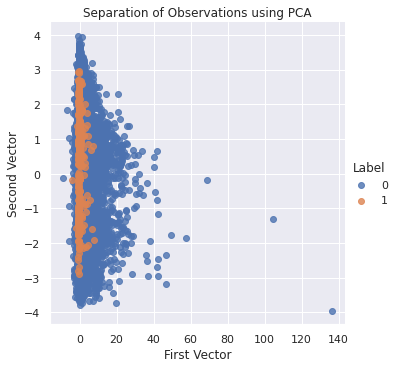

In [ ]:

from sklearn.decomposition import PCA

n_components = 30
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

Dòng nào mà càng gần 0 thì không phải fraud do sự khác biệt giữa reduce và original rất thấp, dòng nào mà càng gần 1 thì có thể là fraud do sự khác biệt cao. Đây là y_pred_proba

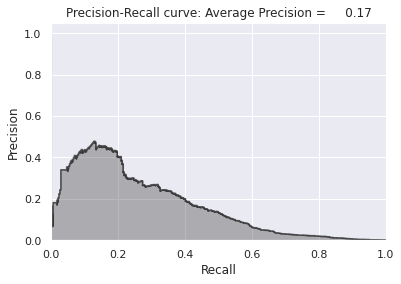

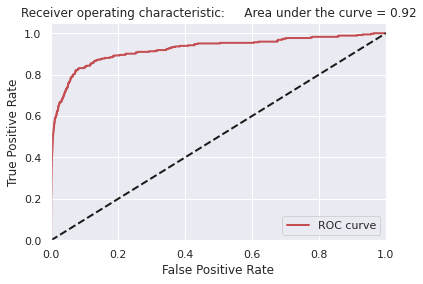

In [ ]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

## 27 principal components

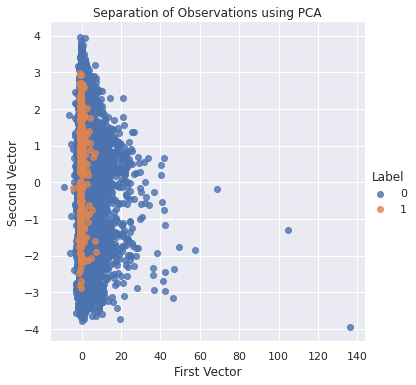

In [9]:

from sklearn.decomposition import PCA

n_components = 27
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

In [10]:
X_train_PCA

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
252400,-0.508088,-1.506485,-0.071880,-0.038343,0.229346,-0.193977,0.285010,0.412106,0.400477,0.928664,-0.043409,-1.636387,0.129640,-0.002989,-0.482130,-0.601434,0.287101,-0.241197,-0.737820,0.579668,0.143145,0.669756,0.460601,0.258255,-0.026964,0.133462,0.014392
171895,-0.442091,-1.093209,-0.080804,-0.236439,0.178684,0.537510,0.237949,0.581623,-0.295339,0.520194,-0.420805,0.620514,-1.349463,-0.737664,0.851762,-0.220937,-1.917696,-1.230672,1.328246,-0.511973,0.298184,-0.137833,1.482811,2.364784,-0.599009,0.082672,-0.181281
135426,-0.226349,0.973079,-0.224498,-0.194274,-0.530226,-0.112232,-0.014372,-0.408586,-0.993959,-1.455895,-2.394934,-0.485213,1.157712,-1.065089,0.111535,-0.573349,-1.401674,1.354313,-0.170720,0.923917,-1.142264,-0.153252,0.916259,-0.740263,1.212968,-0.397832,-0.016663
178814,-1.763898,-3.302012,1.817437,5.677822,9.419994,-4.519907,4.652623,-0.095031,0.288564,0.600519,0.074739,1.311149,-1.229917,3.516049,1.405965,2.412172,0.158547,1.587778,-0.955815,-0.343429,0.008139,-0.603746,1.565352,-0.250441,3.139623,-0.573218,7.081483
129784,-0.455159,0.820537,0.165971,0.025011,0.077766,-0.549667,-0.116892,-0.382440,1.441218,1.531977,0.490933,-0.207296,-0.158388,-0.101557,1.512572,-0.359846,0.522189,-0.528897,0.656788,-0.332159,-1.577882,0.945307,1.683417,-0.893470,0.131088,-0.156574,-0.617760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195475,6.670826,-1.440063,-0.299731,0.193084,-1.492198,0.037747,-1.836641,-0.335993,0.119756,-0.194029,0.773229,-1.233847,-0.425824,-0.106464,0.192057,0.138455,-0.350711,-1.017303,1.166180,0.307435,1.242278,-0.970513,-1.746040,1.410572,-0.747232,1.014901,0.800388
48687,2.753566,0.948938,-0.003775,0.121997,-0.540640,-0.104641,-0.397662,-0.104835,0.905808,0.025112,0.273854,-1.467772,0.907353,0.202097,-0.400752,-1.065411,0.304850,-1.691851,-0.364886,-0.170145,1.498739,-0.021009,-0.015487,0.856849,-0.476690,0.391382,0.470295
159608,-0.442582,-1.077595,-0.055713,-0.159395,-0.069116,-0.008653,0.377661,-0.321883,0.331426,-0.102818,-0.424048,-0.841547,1.258658,0.757143,-0.301258,-1.055521,0.810382,0.036158,-1.478100,-1.035070,0.907820,-0.597489,0.423387,0.411260,0.016714,-0.605638,0.339938
205176,8.093622,-1.401660,-0.279210,0.367432,-1.672291,0.245403,-2.575394,0.511866,-0.219496,1.528896,0.087433,-2.058523,0.029253,-0.110381,-2.369846,-0.270898,-1.083185,-1.601649,-0.581638,-1.616060,-0.865251,-0.276884,-0.988113,-0.543867,-0.397043,-0.499493,0.566108


In [11]:
X_train_PCA_inverse

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
252400,1.077889,1.098982,-0.009867,-0.826464,0.239932,0.009400,-0.895256,0.207579,-0.309029,0.435086,0.079199,-0.783309,0.721634,0.526315,0.169148,-0.061774,-0.108879,-0.398811,-1.047413,0.210581,-0.269406,-0.376605,-0.884934,0.542820,-0.023946,-0.592387,0.397667,-0.165531,-0.179981,-0.334516
171895,0.777586,0.975048,-0.449958,-0.949961,-0.423241,1.160744,2.965819,-1.080825,0.900064,1.019236,0.023959,-0.135371,0.343342,-0.000800,-0.022349,0.900090,0.285045,-0.626883,-0.177686,-0.495028,-0.132505,0.204761,0.727328,0.310645,1.259310,-0.389778,1.235269,0.004199,-0.155347,-0.290176
135426,-0.664560,-0.661736,0.326384,1.495554,1.823181,-0.023947,1.225153,-0.490027,0.901828,-0.550954,-0.219419,-0.168907,1.391292,0.359517,-0.664083,-2.866006,-0.563321,0.685864,-0.367319,0.919050,0.100356,-0.097591,-0.155726,-0.215378,-0.447883,0.312866,0.186620,0.010656,-0.174150,-0.180166
178814,2.363870,-4.656053,-4.414131,-1.621555,1.183582,3.579789,-2.322967,-1.142165,-4.368638,1.290760,0.463510,-1.006168,-0.476717,0.056591,0.523269,0.358477,-0.028169,-1.167102,-0.738476,0.699490,-8.901800,2.862386,0.982626,4.670329,-1.303121,1.395077,-0.157534,7.585880,-1.509818,-1.443107
129784,-0.574023,0.639404,-0.156479,0.416368,-0.566556,-0.593572,-0.272490,-0.461461,0.002014,1.412350,-1.115414,-0.008976,1.651310,1.508066,-0.540746,1.405516,-0.967944,-0.055240,-0.541185,0.254583,-0.095556,0.045663,0.698020,-0.028216,0.229373,0.828475,-1.385532,0.279270,0.091930,-0.334861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195475,0.852079,-0.299334,-2.861493,-2.044675,0.733913,-0.853371,0.098108,1.439870,-0.324389,0.287239,-0.202724,0.294417,-0.308487,-1.626795,1.373008,0.445902,0.776825,-0.833856,1.086361,-0.235843,3.242596,1.401842,-0.260529,-1.844915,0.613341,-0.837353,1.299596,-0.887100,0.465352,4.824781
48687,-0.741921,0.026556,-1.166010,-0.290168,0.221558,-0.671664,-0.331125,0.633753,-0.274458,0.201830,-0.466160,-0.832216,-0.194462,0.146788,0.455817,1.407275,0.607034,-0.613921,-0.336443,0.344536,1.550735,0.082957,-1.659323,-0.860882,-0.612512,0.216261,1.754212,-0.500175,0.302525,1.966174
159608,0.769326,-0.011683,0.525254,0.134607,-0.514642,0.555547,-0.369663,0.728452,-0.092245,0.030726,-0.412693,-1.677010,-0.334063,0.168795,0.101720,-0.245956,0.219761,-0.910248,-0.541802,0.366707,0.020047,-0.478657,-1.134591,-0.103421,-1.663171,-0.542503,0.445774,0.599634,0.263912,-0.286406
205176,0.774240,-0.499461,-3.819353,-1.728960,0.320522,-1.842958,0.230246,1.058391,-0.368524,0.087685,-0.080290,-1.202139,-0.731061,-0.449326,-0.001358,-0.144050,1.443846,0.461329,-1.552045,0.597007,4.207999,1.025480,-2.120510,-1.559914,0.985799,-2.053878,-1.590792,-0.743388,0.727019,5.854779


In [ ]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
anomalyScoresPCA

252400    0.000037
171895    0.000046
135426    0.000124
178814    0.003827
129784    0.000063
            ...   
195475    0.000039
48687     0.000101
159608    0.000135
205176    0.000053
197673    0.000734
Length: 199364, dtype: float64

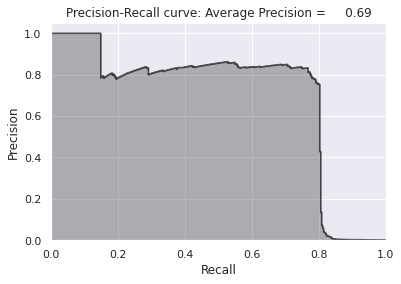

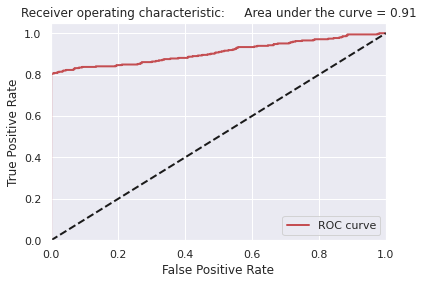

In [ ]:
preds = plotResults(y_train, anomalyScoresPCA, True)

Best Threshold=0.027314, F-Score=0.799


Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.69')

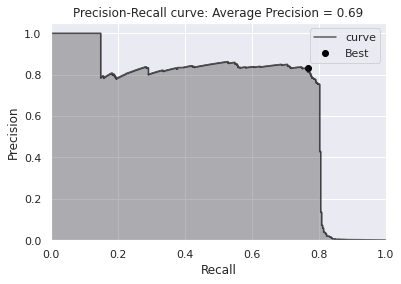

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_train,anomalyScoresPCA)
average_precision = average_precision_score(y_train,anomalyScoresPCA)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
best_threshold=thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (best_threshold, fscore[ix]))

# plot the roc curve for the model
plt.step(recall, precision, color='k', alpha=0.7, where='post',label='curve')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend()
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

In [ ]:
precision

array([0.00175977, 0.00175466, 0.00175467, ..., 1.        , 1.        ,
       1.        ])

In [ ]:
best_threshold=0.5 # Normal threshold if not tunning
y_pred_new = [1 if x >= best_threshold else 0 for x in anomalyScoresPCA]
confmat = confusion_matrix(y_train,y_pred_new)
print('accuracy_score: \n',accuracy_score(y_train, y_pred_new))
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_train, y_pred_new))

accuracy_score: 
 0.998530326438073
confusion_matrix 
 [[199020      0]
 [   293     51]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       1.00      0.15      0.26       344

    accuracy                           1.00    199364
   macro avg       1.00      0.57      0.63    199364
weighted avg       1.00      1.00      1.00    199364



In [ ]:
best_threshold=best_threshold
y_pred_new = [1 if x >= best_threshold else 0 for x in anomalyScoresPCA]
confmat = confusion_matrix(y_train,y_pred_new)
print('accuracy_score: \n',accuracy_score(y_train, y_pred_new))
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_train, y_pred_new))

accuracy_score: 
 0.999332878553801
confusion_matrix 
 [[198967     53]
 [    80    264]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.83      0.77      0.80       344

    accuracy                           1.00    199364
   macro avg       0.92      0.88      0.90    199364
weighted avg       1.00      1.00      1.00    199364



y_ pred

In [ ]:
X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(data=X_test_PCA, index=X_test.index)

X_test_PCA_inverse = pca.inverse_transform(X_test_PCA)
X_test_PCA_inverse = pd.DataFrame(data=X_test_PCA_inverse,index=X_test.index)

In [ ]:
anomalyScoresPCA = anomalyScores(X_test, X_test_PCA_inverse)
best_threshold=best_threshold
y_pred_new = [1 if x >= best_threshold else 0 for x in anomalyScoresPCA]
confmat = confusion_matrix(y_test,y_pred_new)
print('accuracy_score: \n',accuracy_score(y_test, y_pred_new))
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_test, y_pred_new))

accuracy_score: 
 0.9992392589211521
confusion_matrix 
 [[85263    32]
 [   33   115]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.78      0.78      0.78       148

    accuracy                           1.00     85443
   macro avg       0.89      0.89      0.89     85443
weighted avg       1.00      1.00      1.00     85443



Test function (same as above)

In [ ]:
def train_performance_calculation(y_train,anomalyScoresPCA):
  # Training set
  precision, recall, thresholds = precision_recall_curve(y_train,anomalyScoresPCA)
  average_precision = average_precision_score(y_train,anomalyScoresPCA)
  # convert to f score
  fscore = (2 * precision * recall) / (precision + recall)
  # locate the index of the largest f score
  ix = np.argmax(fscore)
  best_threshold=thresholds[ix]
  print('Best Threshold=%f, F-Score=%.3f' % (best_threshold, fscore[ix]))

  y_pred_new = [1 if x >= best_threshold else 0 for x in anomalyScoresPCA]
  confmat = confusion_matrix(y_train,y_pred_new)
  print('Training performance')
  print('accuracy_score: \n',accuracy_score(y_train, y_pred_new))
  print('confusion_matrix \n',confmat)
  print('classification_report \n',classification_report(y_train, y_pred_new))
  return best_threshold

def test_performance_calculation(X_test,y_test,PCA,best_threshold):
  # Test set
  X_test_PCA = pca.transform(X_test)
  X_test_PCA = pd.DataFrame(data=X_test_PCA, index=X_test.index)

  X_test_PCA_inverse = pca.inverse_transform(X_test_PCA)
  X_test_PCA_inverse = pd.DataFrame(data=X_test_PCA_inverse,index=X_test.index)

  anomalyScoresPCA = anomalyScores(X_test, X_test_PCA_inverse)
  best_threshold=best_threshold
  y_pred_new = [1 if x >= best_threshold else 0 for x in anomalyScoresPCA]
  confmat = confusion_matrix(y_test,y_pred_new)
  print('Testing performance')
  print('accuracy_score: \n',accuracy_score(y_test, y_pred_new))
  print('confusion_matrix \n',confmat)
  print('classification_report \n',classification_report(y_test, y_pred_new))

In [ ]:
from sklearn.decomposition import PCA

n_components = 27
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)

In [ ]:
best_threshold=train_performance_calculation(y_train,anomalyScoresPCA)

Best Threshold=0.027314, F-Score=0.799
Training performance
accuracy_score: 
 0.999332878553801
confusion_matrix 
 [[198967     53]
 [    80    264]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.83      0.77      0.80       344

    accuracy                           1.00    199364
   macro avg       0.92      0.88      0.90    199364
weighted avg       1.00      1.00      1.00    199364



In [ ]:
test_performance_calculation(X_test,y_test,pca,best_threshold)

Testing performance
accuracy_score: 
 0.9992392589211521
confusion_matrix 
 [[85263    32]
 [   33   115]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.78      0.78      0.78       148

    accuracy                           1.00     85443
   macro avg       0.89      0.89      0.89     85443
weighted avg       1.00      1.00      1.00     85443



# Sparse PCA OK

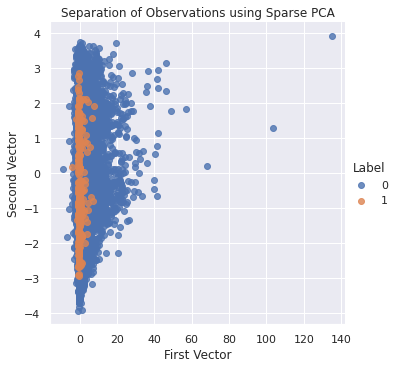

In [ ]:

from sklearn.decomposition import SparsePCA

n_components = 27
alpha = 0.0001
random_state = 2018
n_jobs = -1

sparsePCA = SparsePCA(n_components=n_components, \
                alpha=alpha, random_state=random_state, n_jobs=n_jobs)

sparsePCA.fit(X_train.loc[:,:])
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=X_train.index)

scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

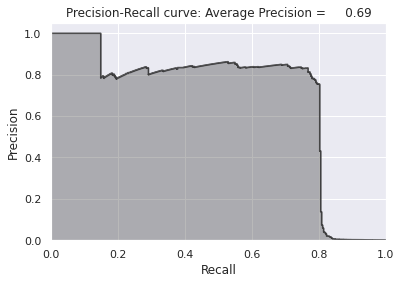

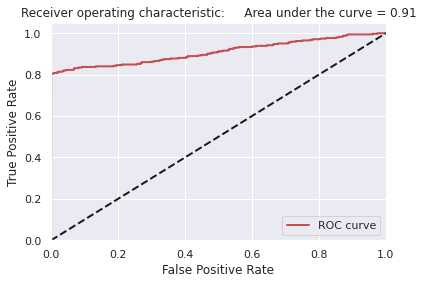

In [ ]:
X_train_sparsePCA_inverse = np.array(X_train_sparsePCA). \
    dot(sparsePCA.components_) + np.array(X_train.mean(axis=0))
X_train_sparsePCA_inverse = \
    pd.DataFrame(data=X_train_sparsePCA_inverse, index=X_train.index)

anomalyScoresSparsePCA = anomalyScores(X_train, X_train_sparsePCA_inverse)
preds = plotResults(y_train, anomalyScoresSparsePCA, True)

Best Threshold=0.027314, F-Score=0.799


Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.69')

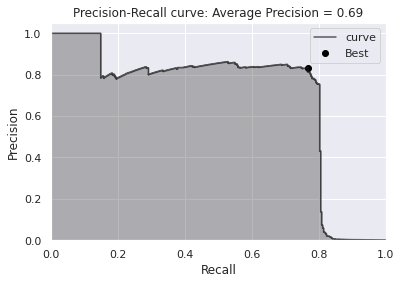

In [ ]:
anomalyScoresSparsePCA = anomalyScores(X_train, X_train_sparsePCA_inverse)
precision, recall, thresholds = precision_recall_curve(y_train,anomalyScoresSparsePCA)
average_precision = average_precision_score(y_train,anomalyScoresSparsePCA)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
best_threshold=thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (best_threshold_2, fscore[ix]))

# plot the roc curve for the model
plt.step(recall, precision, color='k', alpha=0.7, where='post',label='curve')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend()
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

In [ ]:
anomalyScoresSparsePCA = anomalyScores(X_train, X_train_sparsePCA_inverse)
best_threshold=best_threshold
y_pred_new = [1 if x >= best_threshold else 0 for x in anomalyScoresSparsePCA]
confmat = confusion_matrix(y_train,y_pred_new)
print('accuracy_score: \n',accuracy_score(y_train, y_pred_new))
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_train, y_pred_new))

accuracy_score: 
 0.999332878553801
confusion_matrix 
 [[198967     53]
 [    80    264]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.83      0.77      0.80       344

    accuracy                           1.00    199364
   macro avg       0.92      0.88      0.90    199364
weighted avg       1.00      1.00      1.00    199364



In [ ]:
X_test_sparsePCA = sparsePCA.transform(X_test)
X_test_sparsePCA = pd.DataFrame(data=X_test_sparsePCA, index=X_test.index)
X_test_sparsePCA_inverse = np.array(X_test_sparsePCA). \
    dot(sparsePCA.components_) + np.array(X_test.mean(axis=0))
X_test_sparsePCA_inverse = \
    pd.DataFrame(data=X_test_sparsePCA_inverse, index=X_test.index)

anomalyScoresPCA = anomalyScores(X_test, X_test_sparsePCA_inverse)
best_threshold=best_threshold
y_pred_new = [1 if x >= best_threshold else 0 for x in anomalyScoresPCA]
confmat = confusion_matrix(y_test,y_pred_new)
print('accuracy_score: \n',accuracy_score(y_test, y_pred_new))
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_test, y_pred_new))

accuracy_score: 
 0.9992392589211521
confusion_matrix 
 [[85263    32]
 [   33   115]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.78      0.78      0.78       148

    accuracy                           1.00     85443
   macro avg       0.89      0.89      0.89     85443
weighted avg       1.00      1.00      1.00     85443



Use function instead (same as above)

In [ ]:
best_threshold=train_performance_calculation(y_train,anomalyScoresSparsePCA)
test_performance_calculation(X_test,y_test,sparsePCA,best_threshold)

Best Threshold=0.027316, F-Score=0.799
Training performance
accuracy_score: 
 0.999332878553801
confusion_matrix 
 [[198967     53]
 [    80    264]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.83      0.77      0.80       344

    accuracy                           1.00    199364
   macro avg       0.92      0.88      0.90    199364
weighted avg       1.00      1.00      1.00    199364

Testing performance
accuracy_score: 
 0.9992392589211521
confusion_matrix 
 [[85263    32]
 [   33   115]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.78      0.78      0.78       148

    accuracy                           1.00     85443
   macro avg       0.89      0.89      0.89     85443
weighted avg       1.00      1.00      1.00     85443



# Kernel PCA

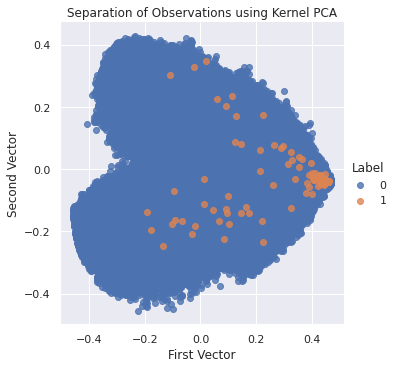

In [ ]:

from sklearn.decomposition import KernelPCA

n_components = 27
kernel = 'rbf'
gamma = None
fit_inverse_transform = True
random_state = 2018
n_jobs = 1

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, \
                gamma=gamma, fit_inverse_transform= \
                fit_inverse_transform, n_jobs=n_jobs, \
                random_state=random_state)

kernelPCA.fit(X_train.iloc[:2000])
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA, \
                                 index=X_train.index)

X_train_kernelPCA_inverse = kernelPCA.inverse_transform(X_train_kernelPCA)
X_train_kernelPCA_inverse = pd.DataFrame(data=X_train_kernelPCA_inverse, \
                                         index=X_train.index)

scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

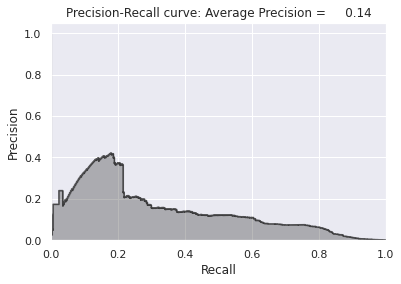

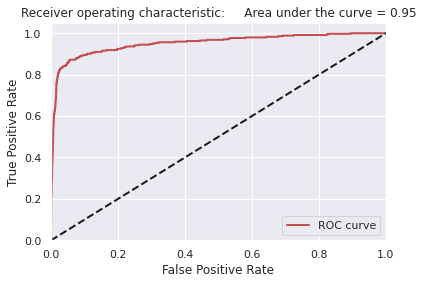

In [ ]:
anomalyScoresKernelPCA = anomalyScores(X_train, X_train_kernelPCA_inverse)
preds = plotResults(y_train, anomalyScoresKernelPCA, True)

AOC

Precision curve

In [ ]:
best_threshold=train_performance_calculation(y_train,anomalyScoresKernelPCA)
test_performance_calculation(X_test,y_test,kernelPCA,best_threshold)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning:

invalid value encountered in true_divide



Best Threshold=0.139664, F-Score=nan
Training performance
accuracy_score: 
 0.9982394012961217
confusion_matrix 
 [[199013      7]
 [   344      0]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.00      0.00      0.00       344

    accuracy                           1.00    199364
   macro avg       0.50      0.50      0.50    199364
weighted avg       1.00      1.00      1.00    199364

Testing performance
accuracy_score: 
 0.9988062216916541
confusion_matrix 
 [[85279    16]
 [   86    62]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.79      0.42      0.55       148

    accuracy                           1.00     85443
   macro avg       0.90      0.71      0.77     85443
weighted avg       1.00      1.00      1.00     85443



# Gaussian Random Projection

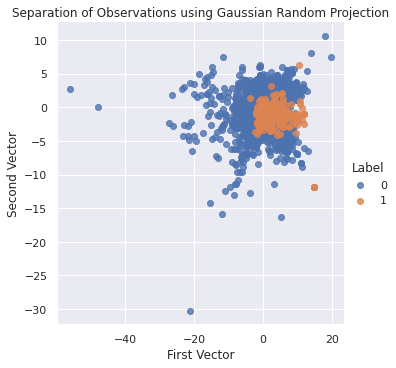

In [ ]:

from sklearn.random_projection import GaussianRandomProjection

n_components = 27
eps = None
random_state = 2018

GRP = GaussianRandomProjection(n_components=n_components, \
                               eps=eps, random_state=random_state)

X_train_GRP = GRP.fit_transform(X_train)
X_train_GRP = pd.DataFrame(data=X_train_GRP, index=X_train.index)

scatterPlot(X_train_GRP, y_train, "Gaussian Random Projection")

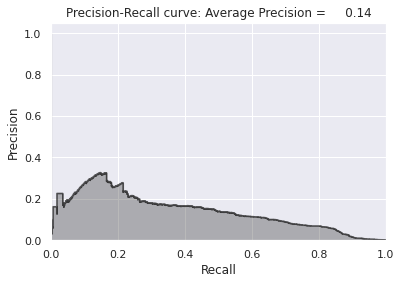

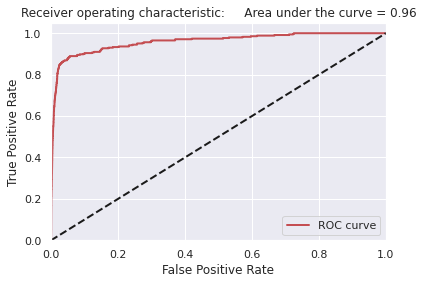

In [ ]:
X_train_GRP_inverse = np.array(X_train_GRP).dot(GRP.components_)
X_train_GRP_inverse = pd.DataFrame(data=X_train_GRP_inverse, \
                                   index=X_train.index)

anomalyScoresGRP = anomalyScores(X_train, X_train_GRP_inverse)
preds = plotResults(y_train, anomalyScoresGRP, True)

AOC

In [ ]:
def train_performance_ROC(y_train,anomalyScoresMiniBatchDictLearning):
  fpr, tpr, thresholds = roc_curve(y_train,anomalyScoresMiniBatchDictLearning)
  # get the best threshold
  J = tpr - fpr
  ix = np.argmax(J)
  best_thresh = thresholds[ix]
  print('Best Threshold=%f' % (best_thresh))
  # plot the roc curve for the model
  plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
  plt.plot(fpr, tpr, marker='.', label='ROC curve')
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  # show the plot
  plt.show()

  best_threshold=best_thresh
  y_pred_new = [1 if x >= best_threshold else 0 for x in anomalyScoresMiniBatchDictLearning]
  confmat = confusion_matrix(y_train,y_pred_new)
  print('Training performance')
  print('accuracy_score: \n',accuracy_score(y_train, y_pred_new))
  print('confusion_matrix \n',confmat)
  print('classification_report \n',classification_report(y_train, y_pred_new))
  return best_threshold


Best Threshold=0.000743


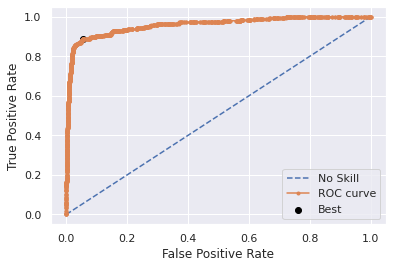

Training performance
accuracy_score: 
 0.9434752512991312
confusion_matrix 
 [[187789  11231]
 [    38    306]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    199020
           1       0.03      0.89      0.05       344

    accuracy                           0.94    199364
   macro avg       0.51      0.92      0.51    199364
weighted avg       1.00      0.94      0.97    199364

Testing performance
accuracy_score: 
 0.9471460505834299
confusion_matrix 
 [[80807  4488]
 [   28   120]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     85295
           1       0.03      0.81      0.05       148

    accuracy                           0.95     85443
   macro avg       0.51      0.88      0.51     85443
weighted avg       1.00      0.95      0.97     85443



In [ ]:
best_threshold=train_performance_ROC(y_train,anomalyScoresGRP)
test_performance_calculation(X_test,y_test,GRP,best_threshold)

Precision curve

In [ ]:
best_threshold=train_performance_calculation(y_train,anomalyScoresGRP)
test_performance_calculation(X_test,y_test,GRP,best_threshold)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning:

invalid value encountered in true_divide



Best Threshold=0.094904, F-Score=nan
Training performance
accuracy_score: 
 0.9982293693946751
confusion_matrix 
 [[199011      9]
 [   344      0]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.00      0.00      0.00       344

    accuracy                           1.00    199364
   macro avg       0.50      0.50      0.50    199364
weighted avg       1.00      1.00      1.00    199364

Testing performance
accuracy_score: 
 0.9988881476539916
confusion_matrix 
 [[85278    17]
 [   78    70]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.80      0.47      0.60       148

    accuracy                           1.00     85443
   macro avg       0.90      0.74      0.80     85443
weighted avg       1.00      1.00      1.00     85443



# Sparse Random Projection

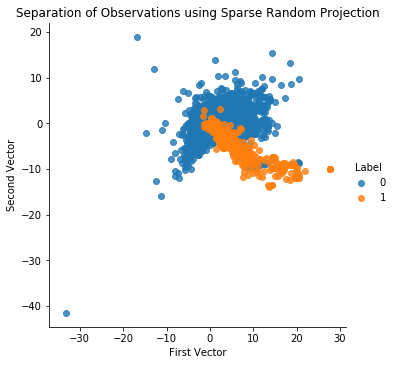

In [ ]:


from sklearn.random_projection import SparseRandomProjection

n_components = 27
density = 'auto'
eps = .01
dense_output = True
random_state = 2018

SRP = SparseRandomProjection(n_components=n_components, \
        density=density, eps=eps, dense_output=dense_output, \
                                random_state=random_state)

X_train_SRP = SRP.fit_transform(X_train)
X_train_SRP = pd.DataFrame(data=X_train_SRP, index=X_train.index)

scatterPlot(X_train_SRP, y_train, "Sparse Random Projection")

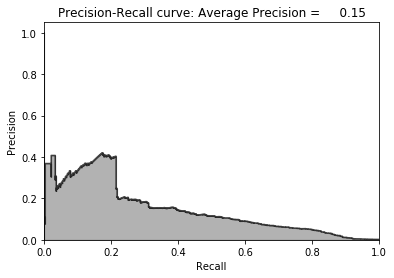

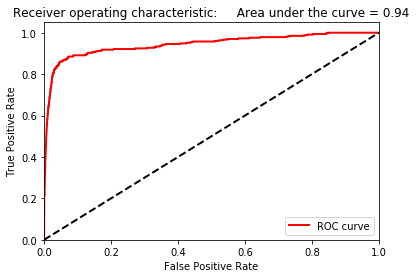

In [ ]:
X_train_SRP_inverse = np.array(X_train_SRP).dot(SRP.components_.todense())
X_train_SRP_inverse = pd.DataFrame(data=X_train_SRP_inverse, index=X_train.index)

anomalyScoresSRP = anomalyScores(X_train, X_train_SRP_inverse)
plotResults(y_train, anomalyScoresSRP)

# Mini-batch dictionary learning

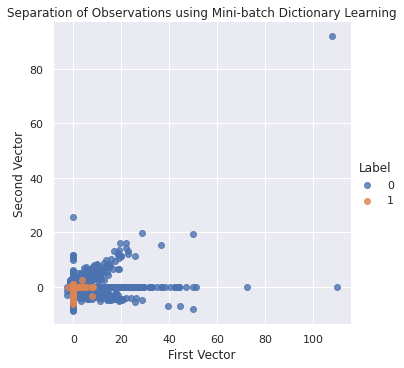

In [ ]:

from sklearn.decomposition import MiniBatchDictionaryLearning

n_components = 28
alpha = 1
batch_size = 200
n_iter = 10
random_state = 2018

miniBatchDictLearning = MiniBatchDictionaryLearning( \
    n_components=n_components, alpha=alpha, batch_size=batch_size, \
    n_iter=n_iter, random_state=random_state)

miniBatchDictLearning.fit(X_train)
X_train_miniBatchDictLearning = \
    miniBatchDictLearning.fit_transform(X_train)
X_train_miniBatchDictLearning = \
    pd.DataFrame(data=X_train_miniBatchDictLearning, index=X_train.index)

scatterPlot(X_train_miniBatchDictLearning, y_train, \
            "Mini-batch Dictionary Learning")

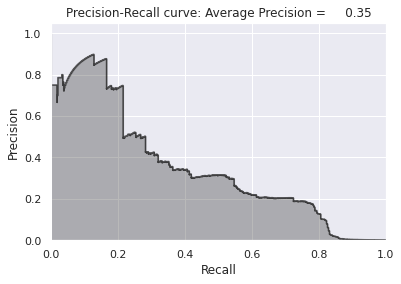

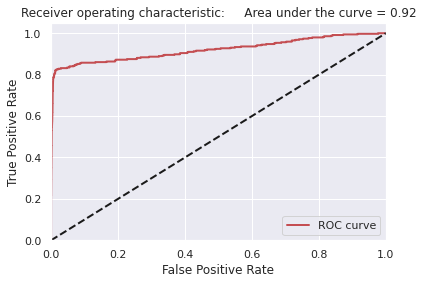

In [ ]:
X_train_miniBatchDictLearning_inverse = \
    np.array(X_train_miniBatchDictLearning). \
    dot(miniBatchDictLearning.components_)

X_train_miniBatchDictLearning_inverse = \
    pd.DataFrame(data=X_train_miniBatchDictLearning_inverse, \
                 index=X_train.index)

anomalyScoresMiniBatchDictLearning = anomalyScores(X_train, \
    X_train_miniBatchDictLearning_inverse)
preds = plotResults(y_train, anomalyScoresMiniBatchDictLearning, True)

DNN use ROC curve

Best Threshold=0.002496


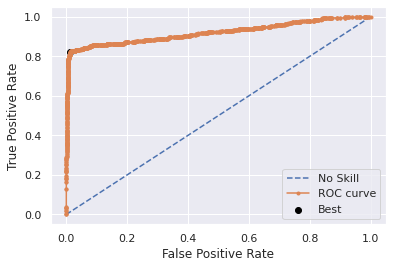

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train,anomalyScoresMiniBatchDictLearning)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='ROC curve')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [ ]:
best_threshold=best_thresh
y_pred_new = [1 if x >= best_threshold else 0 for x in anomalyScoresMiniBatchDictLearning]
confmat = confusion_matrix(y_train,y_pred_new)
print('Training performance')
print('accuracy_score: \n',accuracy_score(y_train, y_pred_new))
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_train, y_pred_new))

Training performance
accuracy_score: 
 0.9862663269196044
confusion_matrix 
 [[196343   2677]
 [    61    283]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    199020
           1       0.10      0.82      0.17       344

    accuracy                           0.99    199364
   macro avg       0.55      0.90      0.58    199364
weighted avg       1.00      0.99      0.99    199364



In [ ]:
test_performance_calculation(X_test,y_test,miniBatchDictLearning,best_threshold)

Testing performance
accuracy_score: 
 0.996278220568098
confusion_matrix 
 [[85007   288]
 [   30   118]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.29      0.80      0.43       148

    accuracy                           1.00     85443
   macro avg       0.65      0.90      0.71     85443
weighted avg       1.00      1.00      1.00     85443



DNN use precision recal for threshold (new) Can not calculate f score

Best Threshold=0.195794, F-Score=nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

invalid value encountered in true_divide



Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.69')

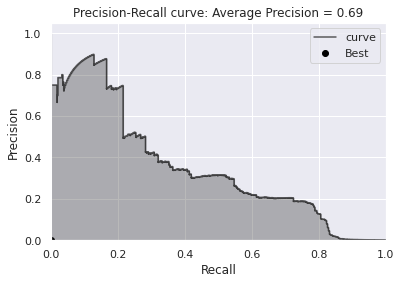

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_train,anomalyScoresMiniBatchDictLearning)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
best_threshold_2=thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (best_threshold_2, fscore[ix]))
# plot the roc curve for the model

plt.step(recall, precision, color='k', alpha=0.7, where='post',label='curve')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend()
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

DNN use precision recal for threshold (old)

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_train,anomalyScoresMiniBatchDictLearning)
average_precision = average_precision_score(y_train,anomalyScoresMiniBatchDictLearning)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
fscore

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in true_divide



array([0.00352665, 0.00351642, 0.00351643, ...,        nan,        nan,
       0.        ])

In [ ]:
# locate the index of the largest f score
ix = np.argmax(fscore)
best_threshold=thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (best_threshold, fscore[ix]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in true_divide



Best Threshold=0.195794, F-Score=nan
Training performance
accuracy_score: 
 0.9982644810497382
confusion_matrix 
 [[199018      2]
 [   344      0]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.00      0.00      0.00       344

    accuracy                           1.00    199364
   macro avg       0.50      0.50      0.50    199364
weighted avg       1.00      1.00      1.00    199364



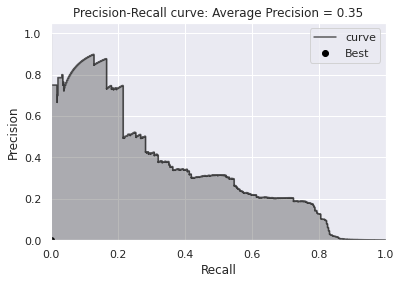

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_train,anomalyScoresMiniBatchDictLearning)
average_precision = average_precision_score(y_train,anomalyScoresMiniBatchDictLearning)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
best_threshold=thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (best_threshold, fscore[ix]))
# plot the roc curve for the model
plt.step(recall, precision, color='k', alpha=0.7, where='post',label='curve')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend()
plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

best_threshold=best_threshold
y_pred_new = [1 if x >= best_threshold else 0 for x in anomalyScoresMiniBatchDictLearning]
confmat = confusion_matrix(y_train,y_pred_new)
print('Training performance')
print('accuracy_score: \n',accuracy_score(y_train, y_pred_new))
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_train, y_pred_new))

In [ ]:
best_threshold=train_performance_calculation(y_train,anomalyScoresMiniBatchDictLearning)
test_performance_calculation(X_test,y_test,miniBatchDictLearning,best_threshold)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning:

invalid value encountered in true_divide



Best Threshold=0.195794, F-Score=nan
Training performance
accuracy_score: 
 0.9982644810497382
confusion_matrix 
 [[199018      2]
 [   344      0]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.00      0.00      0.00       344

    accuracy                           1.00    199364
   macro avg       0.50      0.50      0.50    199364
weighted avg       1.00      1.00      1.00    199364

Testing performance
accuracy_score: 
 0.9988062216916541
confusion_matrix 
 [[85287     8]
 [   94    54]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.87      0.36      0.51       148

    accuracy                           1.00     85443
   macro avg       0.93      0.68      0.76     85443
weighted avg       1.00      1.00      1.00     85443



# Independent Component Analysis OK

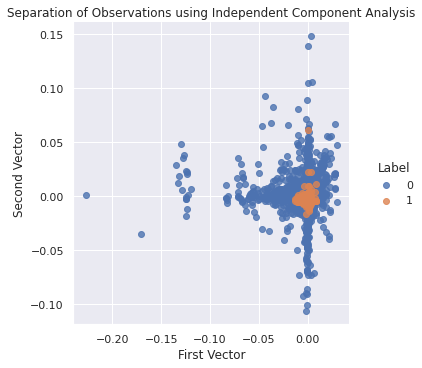

In [ ]:


from sklearn.decomposition import FastICA

n_components = 27
algorithm = 'parallel'
whiten = True
max_iter = 200
random_state = 2018

fastICA = FastICA(n_components=n_components, \
    algorithm=algorithm, whiten=whiten, max_iter=max_iter, \
    random_state=random_state)

X_train_fastICA = fastICA.fit_transform(X_train)
X_train_fastICA = pd.DataFrame(data=X_train_fastICA, index=X_train.index)

X_train_fastICA_inverse = fastICA.inverse_transform(X_train_fastICA)
X_train_fastICA_inverse = pd.DataFrame(data=X_train_fastICA_inverse, \
                                       index=X_train.index)

scatterPlot(X_train_fastICA, y_train, "Independent Component Analysis")

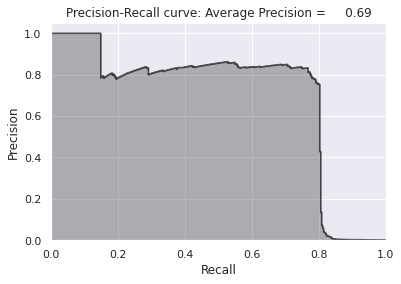

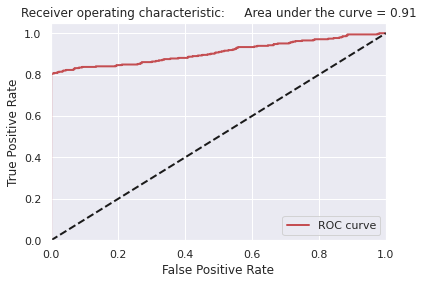

In [ ]:
anomalyScoresFastICA = anomalyScores(X_train, X_train_fastICA_inverse)
plotResults(y_train, anomalyScoresFastICA)

In [ ]:
best_threshold=train_performance_calculation(y_train,anomalyScoresFastICA)
test_performance_calculation(X_test,y_test,fastICA,best_threshold)

Best Threshold=0.027314, F-Score=0.799
Training performance
accuracy_score: 
 0.999332878553801
confusion_matrix 
 [[198967     53]
 [    80    264]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.83      0.77      0.80       344

    accuracy                           1.00    199364
   macro avg       0.92      0.88      0.90    199364
weighted avg       1.00      1.00      1.00    199364

Testing performance
accuracy_score: 
 0.9992392589211521
confusion_matrix 
 [[85263    32]
 [   33   115]]
classification_report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.78      0.78      0.78       148

    accuracy                           1.00     85443
   macro avg       0.89      0.89      0.89     85443
weighted avg       1.00      1.00      1.00     85443



# PCA on Test Set

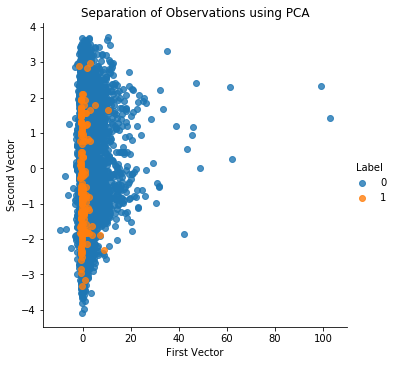

In [ ]:

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(data=X_test_PCA, index=X_test.index)

X_test_PCA_inverse = pca.inverse_transform(X_test_PCA)
X_test_PCA_inverse = pd.DataFrame(data=X_test_PCA_inverse, \
                                  index=X_test.index)

scatterPlot(X_test_PCA, y_test, "PCA")

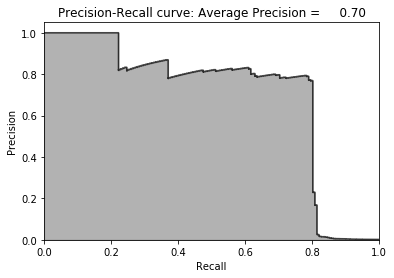

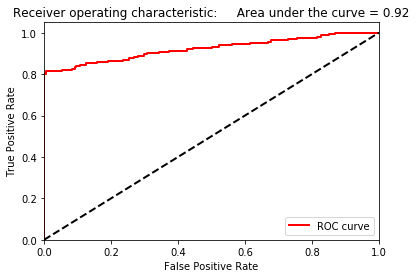

In [ ]:
anomalyScoresPCA = anomalyScores(X_test, X_test_PCA_inverse)
preds = plotResults(y_test, anomalyScoresPCA, True)

# Independent Component Analysis on Test Set

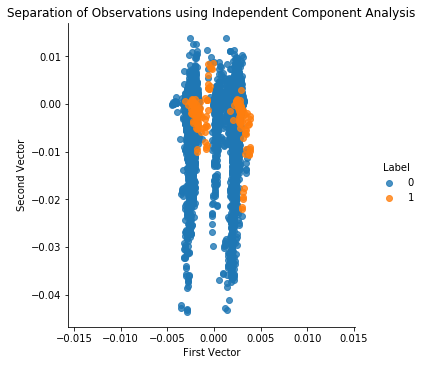

In [ ]:
# Independent Component Analysis on Test Set
X_test_fastICA = fastICA.transform(X_test)
X_test_fastICA = pd.DataFrame(data=X_test_fastICA, index=X_test.index)

X_test_fastICA_inverse = fastICA.inverse_transform(X_test_fastICA)
X_test_fastICA_inverse = pd.DataFrame(data=X_test_fastICA_inverse, \
                                      index=X_test.index)

scatterPlot(X_test_fastICA, y_test, "Independent Component Analysis")

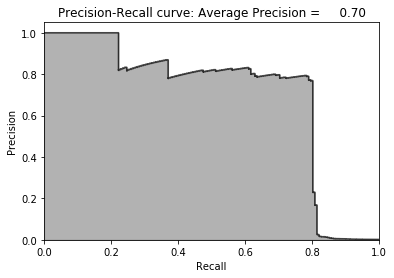

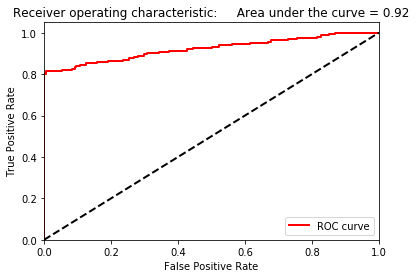

In [ ]:
anomalyScoresFastICA = anomalyScores(X_test, X_test_fastICA_inverse)
plotResults(y_test, anomalyScoresFastICA)

# miniBatchDictLearning

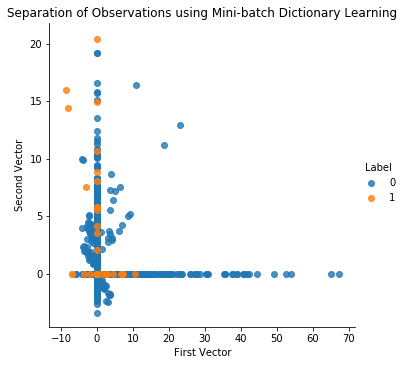

In [ ]:
X_test_miniBatchDictLearning = miniBatchDictLearning.transform(X_test)
X_test_miniBatchDictLearning = \
    pd.DataFrame(data=X_test_miniBatchDictLearning, index=X_test.index)

scatterPlot(X_test_miniBatchDictLearning, y_test, \
            "Mini-batch Dictionary Learning")

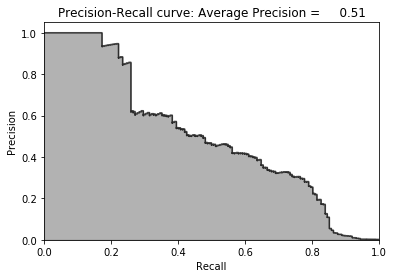

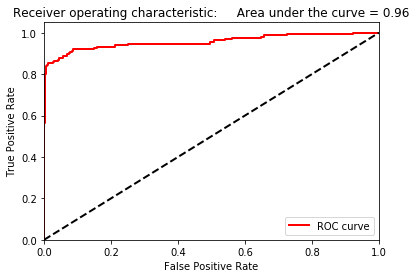

In [ ]:
X_test_miniBatchDictLearning_inverse = \
    np.array(X_test_miniBatchDictLearning). \
    dot(miniBatchDictLearning.components_)

X_test_miniBatchDictLearning_inverse = \
    pd.DataFrame(data=X_test_miniBatchDictLearning_inverse, \
                 index=X_test.index)

anomalyScoresMiniBatchDictLearning = anomalyScores(X_test, \
    X_test_miniBatchDictLearning_inverse)
preds = plotResults(y_test, anomalyScoresMiniBatchDictLearning, True)